In [5]:
import os
import sys
# !{sys.executable} -m pip install python-csv
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install pandas;
# print(pd.__version__)

sys.path.insert(1, 'lib')

import pandas as pd
from display import Display
from mock_db import Database
    
db = Database(os.getcwd(), 'ecov-2021-10-14')   
Display.header('ALP tables', 'h1')

Display.header('Participants table', 'h2')
original_participants_df = db.get_participants()
print('Number of users:', original_participants_df.shape[0])
Display.frame(original_participants_df, 5)

Display.header('Responses table', 'h2')
responses_df = db.get_responses()
print('Number of responses:', responses_df.shape[0])
Display.frame(responses_df.drop(columns=['INTERACTION_ID']), 5)

Number of users: 5159


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE
0,5131,anonymous,enrolled,2021-08-21,NaT
1,5243,anonymous,enrolled,2021-08-20,NaT
2,5110,anonymous,enrolled,2021-08-20,NaT
3,5244,anonymous,enrolled,2021-08-20,NaT
4,5154,anonymous,enrolled,2021-08-20,NaT


Number of responses: 207109


,ALP_ID,VERSION,AUTHORED,QUESTIONNAIRE,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT
1,1496,1.2.0,2021-08-11,corona_testing_and_symptoms,are_new_symptoms,NaN,no,de,"In den letzten 7 Tagen: Hatten Sie neu aufgetretene Symptome (z.B. Husten, Fieber, Halsschmerzen, Schnupfen)?"
2,1496,1.2.0,2021-08-11,corona_testing_and_symptoms,did_get_tested,NaN,no,de,In den letzten 7 Tagen: Wurden Sie auf SARS-CoV-2 getestet?
3,1496,1.2.0,2021-08-05,corona_testing_and_symptoms,are_new_symptoms,NaN,no,de,"In den letzten 7 Tagen: Hatten Sie neu aufgetretene Symptome (z.B. Husten, Fieber, Halsschmerzen, Schnupfen)?"
4,1496,1.2.0,2021-08-05,corona_testing_and_symptoms,did_get_tested,NaN,no,de,In den letzten 7 Tagen: Wurden Sie auf SARS-CoV-2 getestet?
5,1496,1.2.0,2021-07-22,corona_testing_and_symptoms,are_new_symptoms,NaN,no,de,"In den letzten 7 Tagen: Hatten Sie neu aufgetretene Symptome (z.B. Husten, Fieber, Halsschmerzen, Schnupfen)?"


In [3]:
sys.path.insert(1, 'lib')

from display import Display
from study import EcovStudy, ParticipantsBuilder
from datetime import datetime 
import pandas as pd
import math 
from datetime import datetime 
import pandas as pd
import math 

study = EcovStudy()
print('Study:', study.name())
print('Last donation:', responses_df['AUTHORED'].max().strftime("%Y-%m-%d"))

builder = ParticipantsBuilder(study, original_participants_df, responses_df)
participants_df = builder \
    .add_last_donation() \
    .add_all_submissions() \
    .get() \
    .sort_values(by=['Q3'], ascending=False)

Display.header('Participants, enrollment and last donation', 'h2')
Display.frame(participants_df, 3)
Display.text('Number of users: %d' % participants_df.shape[0])

df = participants_df[participants_df['STATUS'] != 'enrolled']
Display.text(f'Left the study: {df.shape[0]}')

Study: eCOV
Last donation: 2021-10-10


,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,LAST_DONATION,all,Q1,Q2,Q3,Q4a,Q4b,Q5a,Q5b,Q6
944,2385,anonymous,enrolled,2021-05-20,NaT,2021-05-20,2021-10-06,37,1,12,6,1,2,1,1,13
3526,2376,anonymous,enrolled,2021-05-05,NaT,2021-05-05,2021-10-06,32,1,15,6,2,1,1,1,5
2186,1571,anonymous,enrolled,2021-05-28,NaT,2021-05-28,2021-10-06,24,1,12,6,1,2,1,1,0


In [6]:
from ecov_utils import ResponsesBuilder, TestManager
from datetime import datetime , timedelta

class AnalyzeGoals():
    MIN_TIME = 8 * 7 # 8 weeks  
    
    def __init__(self, study, participants_df, responses_df):
        self.participants_df = participants_df
        self.tests = TestManager(responses_df).get()
        last_donation = self.participants_df['LAST_DONATION'].max()
        self.threshold_day = last_donation - timedelta(days=AnalyzeGoals.MIN_TIME)
        
    def _get_tests_group_criteria(self):
        df = self.tests.groupby('ALP_ID').agg({'TEST_DATE' : ['count']})
        df.reset_index(inplace=True)
        df.columns = ['ALP_ID', 'COUNT_QUEST.']
        df = df[df['COUNT_QUEST.'] >= 2]
        ids = set(df['ALP_ID'].unique())
        return self.participants_df[self.participants_df['ALP_ID'].isin(ids)].copy()

    def print_title(self, title, text):
        print(f'{title + ":":<50} {text}')
        
    def prin_test_criteria(self):
        Display.header('Tests criteria', 'h2')
        self.print_title('Number of tests', f'{self.tests.shape[0]}')
        self.print_title('Number of users reporting tests', f'{len(self.tests["ALP_ID"].unique())}')

        users_fulfill_test_criteria = self._get_tests_group_criteria()
        self.print_title('Number of users reporting at least 2 tests', f'{users_fulfill_test_criteria.shape[0]}')
        percent = round(100 * users_fulfill_test_criteria.shape[0] / self.participants_df.shape[0], 1)
        self.print_title(f'Percentage from {self.participants_df.shape[0]} users', f'{percent}%')
       
    def prin_time_criteria(self):
        Display.header('Participations 8 weeks and more','h2')       
        
        users_enrolled_before_threshold = self.participants_df[self.participants_df['ENROLED_ON'] < self.threshold_day]
        title = f'Enrolled before {self.threshold_day.strftime("%d.%m.%Y")} (>=8 weeks)'
        self.print_title(title, f'{users_enrolled_before_threshold.shape[0]}')
        
        self.participants_df['TIME_IN_STUDY'] = (self.participants_df['LAST_DONATION'] - self.participants_df['ENROLED_ON']).dt.days
        users_enough_time = self.participants_df[self.participants_df['TIME_IN_STUDY'] >= AnalyzeGoals.MIN_TIME]
        users_enough_time = users_enough_time[users_enough_time['ENROLED_ON'] < self.threshold_day]
        title = f'Participating {AnalyzeGoals.MIN_TIME} days or more'
        self.print_title(title, f'{users_enough_time.shape[0]}')
        
        percent = round(100 * users_enough_time.shape[0] / users_enrolled_before_threshold.shape[0], 1)
        title = f'Percentage from {users_enrolled_before_threshold.shape[0]} users'
        self.print_title(title, f'{percent}%')
        
    def print_okr_criteria(self):
        Display.header('Participations of 8 weeks or report min 2 tests','h2')   
        users_fulfill_test_criteria = self._get_tests_group_criteria()
        users_fulfill_test_criteria['TIME_IN_STUDY'] = (users_fulfill_test_criteria['LAST_DONATION'] - users_fulfill_test_criteria['ENROLED_ON']).dt.days
        tested_short_time_users = users_fulfill_test_criteria[users_fulfill_test_criteria['TIME_IN_STUDY'] < AnalyzeGoals.MIN_TIME]
        title = f'Users tested >=2 and enrolled after {self.threshold_day.strftime("%d.%m.%Y")}'
        self.print_title(title, f'{tested_short_time_users.shape[0]}')
      
        users_enough_time = self.participants_df[self.participants_df['TIME_IN_STUDY'] >= AnalyzeGoals.MIN_TIME]
        count_fulfilling_okrs = users_enough_time.shape[0] + tested_short_time_users.shape[0]
        self.print_title('Users fulfilling at least one criteria', f'{count_fulfilling_okrs}')
        percent = round(100 * count_fulfilling_okrs / self.participants_df.shape[0], 1)
        title = f'Percentage from {self.participants_df.shape[0]} users'
        self.print_title(title, f'{percent}%')
        
    def print_summary(self):
        Display.header('OKRs analysis', 'h1')
        self.print_title('Number of participants', f'{self.participants_df.shape[0]}')
        self.prin_test_criteria()
        self.prin_time_criteria()
        self.print_okr_criteria()

    
pb = ParticipantsBuilder(study, original_participants_df, responses_df).add_last_donation()
participants_df = pb.add_all_submissions().get()
ag = AnalyzeGoals(study, participants_df, responses_df)
ag.print_summary()


Number of participants:                            5159


Number of tests:                                   8356
Number of users reporting tests:                   2805
Number of users reporting at least 2 tests:        1779
Percentage from 5159 users:                        34.5%


Enrolled before 15.08.2021 (>=8 weeks):            2112
Participating 56 days or more:                     858
Percentage from 2112 users:                        40.6%


Users tested >=2 and enrolled after 15.08.2021:    1314
Users fulfilling at least one criteria:            2174
Percentage from 5159 users:                        42.1%


In [75]:
from ecov_utils import Vaccination, TestManager
import matplotlib.ticker as ticker
from study import EcovStudy

v = Vaccination(original_participants_df, responses_df)
tests = v.get_tests()

pos_tests = tests[tests['RESULT'] == 'test_result_pos']
count_all_users = original_participants_df.shape[0]

Display.header('COVID-19 test', 'h1')
Display.header('Tests', 'h2')
print(f'{"Number of tests reported:":<40} {tests.shape[0]}')
print(f'{"Number of positive tests:":<40} {pos_tests.shape[0]}')
Display.header('Participants with tests', 'h2')
print(f'{"All participants:":<40} {count_all_users}')
print(f'{"Participants reporting tests:":<40} {len(tests["ALP_ID"].unique())}')

Number of tests reported:                8355
Number of positive tests:                95


All participants:                        5159
Participants reporting tests:            2805


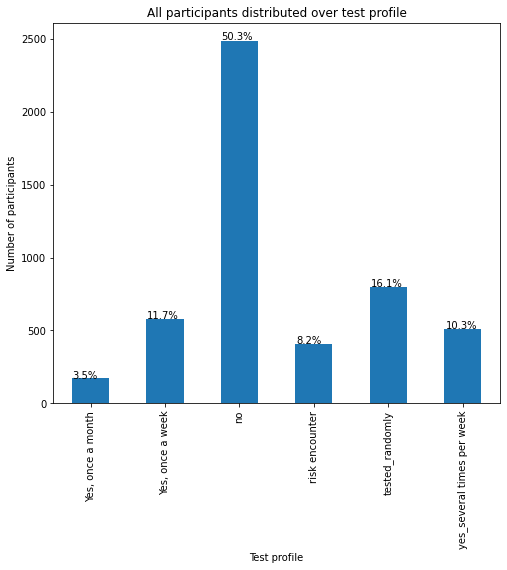

In [13]:
import matplotlib.pyplot as plt

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info', 'regular_testing', 'TEST_PROFILE') \
    .get()

Display.header('Users distributed by their testing behaviour', 'h2')

fig, ax1 = plt.subplots(1,1, figsize=(8,7))
vc = df['TEST_PROFILE'].value_counts().sort_index()
vc.plot(kind="bar", title='All participants distributed over test profile', ax=ax1, ylabel='Number of participants', xlabel='Test profile', legend=None)

for p in ax1.patches:
    value = round(100 * p.get_height()/df[~pd.isnull(df['TEST_PROFILE'])].shape[0],1)
    ax1.annotate(f'{value}%', (p.get_x() * 1.005, p.get_height() * 1.005))

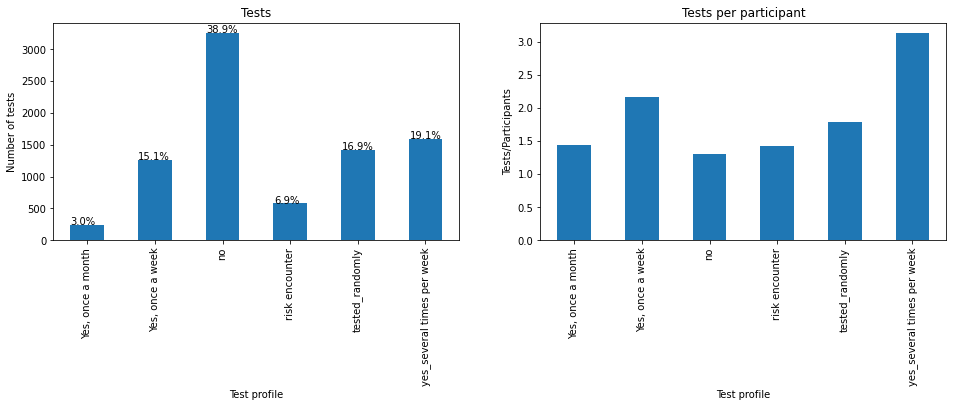

In [14]:
import matplotlib.pyplot as plt

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info', 'regular_testing', 'TEST_PROFILE') \
    .get()

Display.header('Tests distributed by their participant behaviour', 'h2')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

    
vc1 = tests['TEST_PROFILE'].value_counts().sort_index()
vc1.plot(kind="bar", title='Tests', ax=ax1, ylabel='Number of tests', xlabel='Test profile')

for p in ax1.patches:
    value = round(100 * p.get_height() / tests['TEST_PROFILE'].shape[0],1)
    ax1.annotate(f'{value}%', (p.get_x() * 1.005, p.get_height() * 1.005))
    
vc2 = df['TEST_PROFILE'].value_counts().sort_index()
df = pd.merge(vc1.reset_index(), vc2.reset_index(), how='left', on='index')
df.columns = ['TEST_PROFILE', 'TEST', 'PARTICIPANTS']
df['TESTS_PER_PARTICIPANT'] = df['TEST'] / df['PARTICIPANTS']
df = df.drop(['TEST', 'PARTICIPANTS'], axis=1)
df = df.set_index('TEST_PROFILE')
df.plot(kind="bar", title='Tests per participant', ax=ax2, ylabel='Tests/Participants', xlabel='Test profile', legend=None);

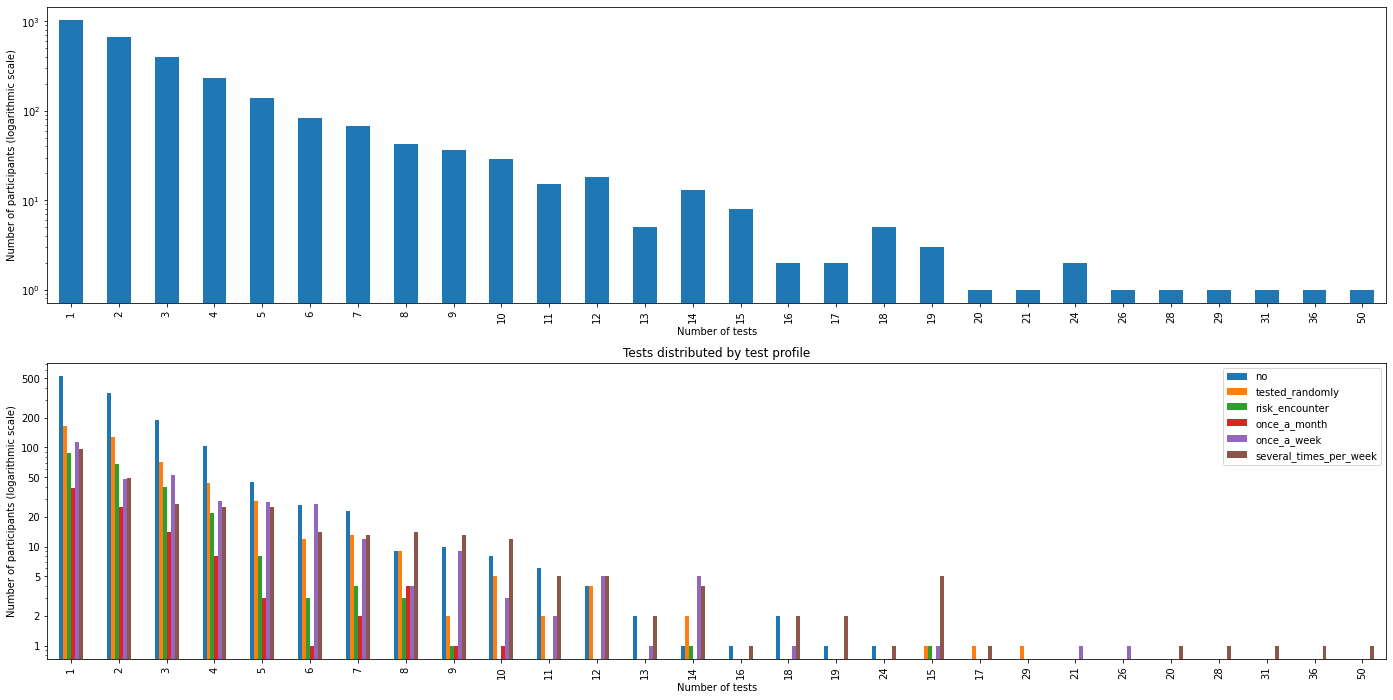

In [15]:
Display.header('Users distributed by number of tests', 'h2')
tests_df = TestManager(responses_df).get()

df = tests_df.groupby('ALP_ID').count().reset_index() 
vc = df['TEST_DATE'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(24,12))

ax1.set_yscale('log')
vc.plot(ax=ax1, kind="bar", 
        ylabel='Number of participants (logarithmic scale)', 
        xlabel='Number of tests');


tests_df = TestManager(responses_df).get()
df = tests_df[['ALP_ID', 'TEST_DATE']].groupby('ALP_ID').count() \
    .reset_index().rename(columns={'TEST_DATE': 'COUNT_TEST'})
participnats_df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('personal_info', 'regular_testing', 'TEST_PROFILE') \
    .get()

df = pd.merge(df, participnats_df, how='left', on='ALP_ID')
df = df.groupby(by=['COUNT_TEST','TEST_PROFILE'])[['ALP_ID']].count().reset_index().rename(columns={'ALP_ID': 'USERS'})

result = df[df['TEST_PROFILE'] == 'no'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'no'})
temp = df[df['TEST_PROFILE'] == 'tested_randomly'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'tested_randomly'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'risk encounter'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'risk_encounter'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'Yes, once a month'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'once_a_month'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'Yes, once a week'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'once_a_week'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'yes_several times per week'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'several_times_per_week'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
result = result.fillna(0).set_index('COUNT_TEST')

ax2.set_yscale('log')
ax2.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500])
ax2.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
result.plot(kind="bar", ax=ax2, title='Tests distributed by test profile',
            ylabel='Number of participants (logarithmic scale)', 
            xlabel='Number of tests');

Participating longer than 8 week: 860
Participating longer than 8 week without tests: 242 (28%)


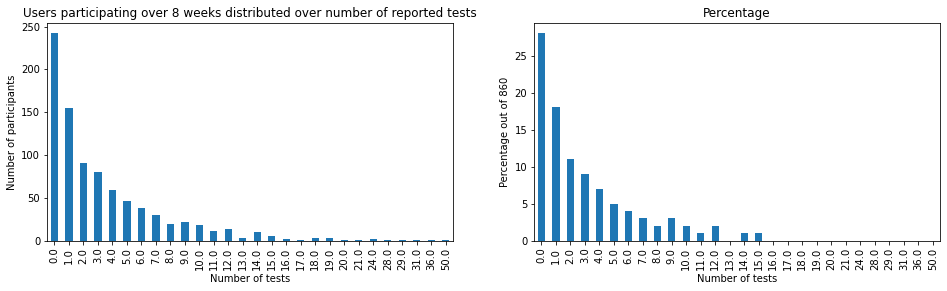

In [16]:
import matplotlib.pyplot as plt

participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .get()
    
tests = TestManager(responses_df).get()
tested_participants = tests.groupby(by=['ALP_ID'])['TEST_DATE'].count() \
    .reset_index().rename(columns={'TEST_DATE': 'COUNT_TESTS'})

participants_df['TIME_IN_STUDY'] = (participants_df['LAST_DONATION'] - participants_df['ENROLED_ON']).dt.days
df = participants_df[participants_df['TIME_IN_STUDY'] >= 8 * 7]
    
df = pd.merge(df, tested_participants, how='left', on='ALP_ID').fillna(0)
vc = df['COUNT_TESTS'].value_counts().sort_index()

Display.header('Tests reported by long time participants', 'h2')
print(f'Participating longer than 8 week: {df.shape[0]}')
print(f'Participating longer than 8 week without tests: {vc[0]} ({round(100 * vc[0]/df.shape[0])}%)')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
vc.plot(kind="bar", ax=ax1, title='Users participating over 8 weeks distributed over number of reported tests',
        ylabel='Number of participants', 
        xlabel='Number of tests');

vc = round(100 * vc/df.shape[0])
vc.plot(kind="bar", ax=ax2, title='Percentage',
        ylabel=f'Percentage out of {df.shape[0]}', 
        xlabel='Number of tests');

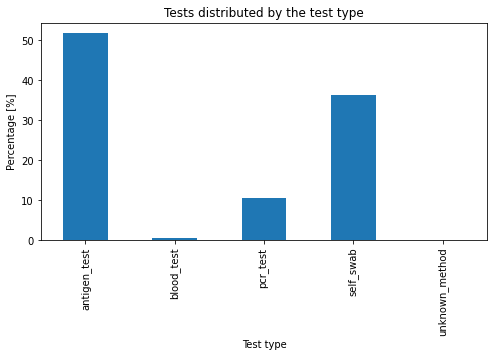

In [17]:
tests = TestManager(responses_df).get()
vc = tests['METHOD'].value_counts().sort_index()
vc = round(100 * vc / tests.shape[0], 1)

Display.header('Tests types', 'h2')
vc.plot(kind="bar", legend=None, title='Tests distributed by the test type', 
        xlabel='Test type', ylabel='Percentage [%]', figsize=(8,4));

all users: 5159
users reporting 1st vaccine date after the second vaccine date: 14 (0.3%)
users reporting the same date for 1st and 2nd vaccines: 49 (0.9%)
users reporting 2nd vaccine lass than 21 days afte the first: 144 (2.8%)


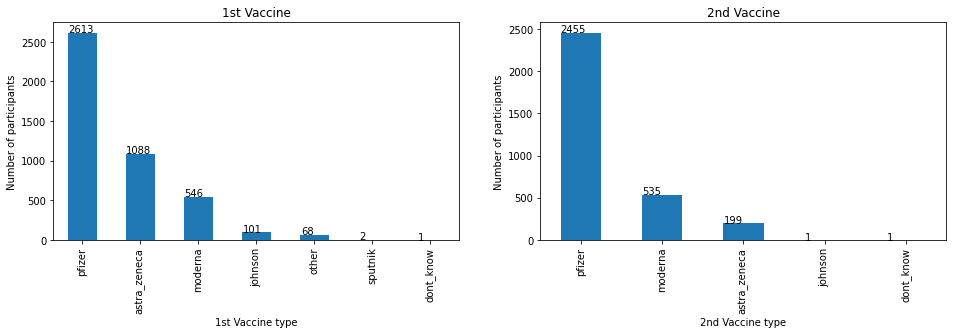

In [9]:
from study import EcovStudy, ParticipantsBuilder

df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('covid_first_vaccine', 'corona_vaccination_received', '1ST_DOSE') \
    .add_choice('covid_first_vaccine', 'which_vaccine_received', '1ST_VACCINE_TYPE') \
    .add_answer('covid_first_vaccine', 'when_vaccinated_first_time', '1ST_VACCINE_DATE') \
    .add_choice('covid_second_vaccine','has_received_second_vacciation', '2ND_DOSE') \
    .add_choice('covid_second_vaccine', 'which_vaccine_received', '2ND_VACCINE_TYPE') \
    .add_answer('covid_second_vaccine', 'when_vaccinated_second_time', '2ND_VACCINE_DATE') \
    .add_choice('personal_info','country_of_residence', 'COUNTRY') \
    .add_last_donation() \
    .get()

df['1ST_VACCINE_DATE'] = pd.to_datetime(df['1ST_VACCINE_DATE'], format='%Y-%m-%d', errors='coerce')
df['2ND_VACCINE_DATE'] = pd.to_datetime(df['2ND_VACCINE_DATE'], format='%Y-%m-%d', errors='coerce')

Display.header('Vaccination', 'h1')

Display.header('Vaccination type', 'h2')
count_all = df['ALP_ID'].count()
print(f'all users: {count_all}')

temp = df[df['1ST_VACCINE_DATE'] > df['2ND_VACCINE_DATE']]
print(f'users reporting 1st vaccine date after the second vaccine date: {temp["ALP_ID"].count()} ({round(100 * temp["ALP_ID"].count() / count_all, 1)}%)')
temp = df[df['1ST_VACCINE_DATE'] == df['2ND_VACCINE_DATE']]
print(f'users reporting the same date for 1st and 2nd vaccines: {temp["ALP_ID"].count()} ({round(100 * temp["ALP_ID"].count() / count_all, 1)}%)')
temp = df[df['1ST_VACCINE_DATE'] + timedelta(days=21) > df['2ND_VACCINE_DATE']]
print(f'users reporting 2nd vaccine lass than 21 days afte the first: {temp["ALP_ID"].count()} ({round(100 * temp["ALP_ID"].count() / count_all, 1)}%)')

def tag_bars(ax, size=None):
    for p in ax.patches:
        value = f'{round(100 * p.get_height() / size, 2)}%' if size else f'{p.get_height()}'
        ax.annotate(value, (p.get_x() * 1.005, p.get_height() * 1.005))
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
vc = df['1ST_VACCINE_TYPE'].value_counts()
vc.plot(kind="bar", title='1st Vaccine', ax=ax1, ylabel='Number of participants', xlabel='1st Vaccine type', legend=None);
tag_bars(ax1)

vc = df['2ND_VACCINE_TYPE'].value_counts()
vc.plot(kind="bar", title='2nd Vaccine', ax=ax2, ylabel='Number of participants', xlabel='2nd Vaccine type', legend=None);
tag_bars(ax2)

Comparing vaccine status on 13.05.2021 with the status today


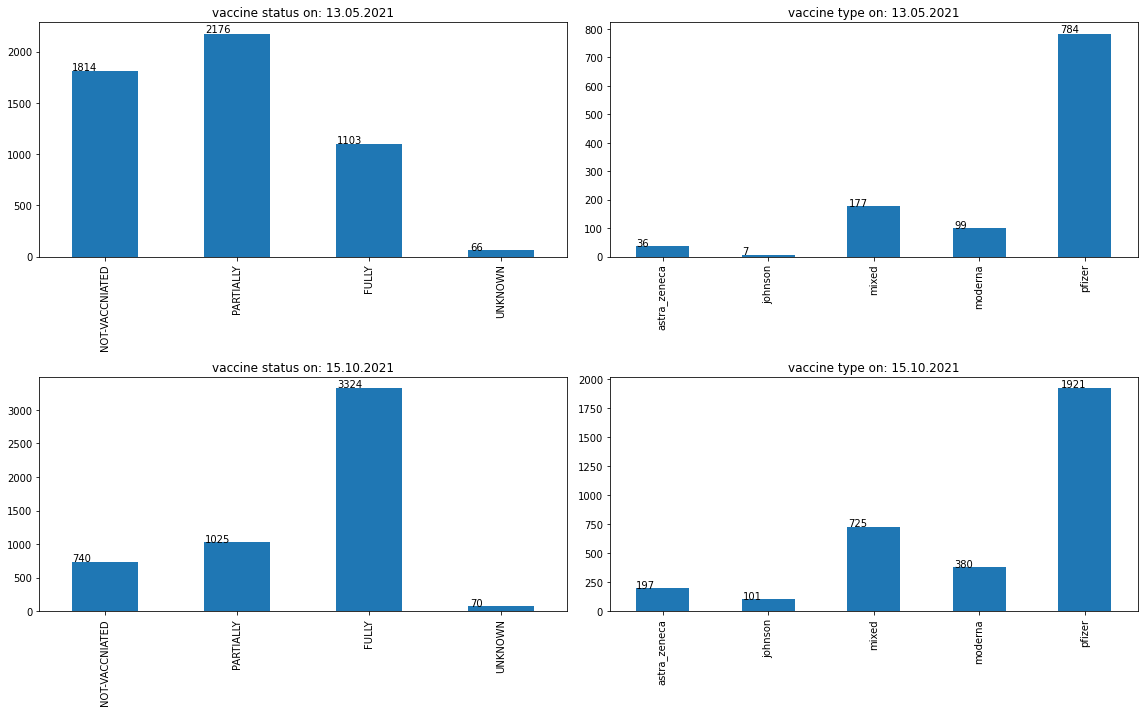

In [10]:
import matplotlib.pyplot as plt
from ecov_utils import Vaccination 
from datetime import datetime

v = Vaccination(original_participants_df, responses_df)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))

day = datetime(2021, 5, 13, 0, 0)
Display.header('Vaccination status', 'h2')
print(f'Comparing vaccine status on {day.strftime("%d.%m.%Y")} with the status today')
      
df = v.get_vaccine_status(day)
value_cnts = df['status'].value_counts()[['NOT-VACCNIATED', 'PARTIALLY', 'FULLY', 'UNKNOWN']]
value_cnts.plot(kind='bar', ax=ax1, title=f'vaccine status on: {day.strftime("%d.%m.%Y")}')
value_cnts = df['type'].value_counts().sort_index()
value_cnts.plot(kind='bar', ax=ax2, title=f'vaccine type on: {day.strftime("%d.%m.%Y")}')

day = datetime.now()
df = v.get_vaccine_status(day)
value_cnts = df['status'].value_counts()[['NOT-VACCNIATED', 'PARTIALLY', 'FULLY', 'UNKNOWN']]
value_cnts.plot(kind='bar', ax=ax3, title=f'vaccine status on: {day.strftime("%d.%m.%Y")}')
value_cnts = df['type'].value_counts().sort_index()
value_cnts.plot(kind='bar', ax=ax4, title=f'vaccine type on: {day.strftime("%d.%m.%Y")}')

for ax in [ax1, ax2, ax3, ax4]:
    tag_bars(ax)
    
fig.tight_layout()

Number of symptoms reported:             526
Number of all participants:              5159
Number of users reporting symptoms:      353 (6.8%)


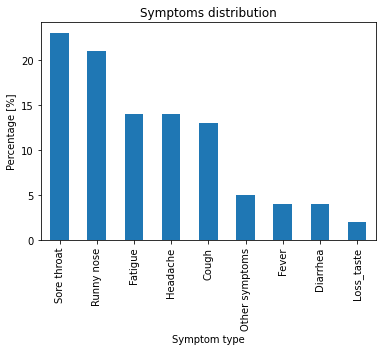

In [4]:
class SymptomManager():
    def __init__(self, study, responses_df):
        self.rb = ResponsesBuilder(responses_df)
        df = self.rb.get_choice('SYMPTOMS', 'which_new_symptoms')
        group_by_columns = ['ALP_ID', 'INTERACTION_ID', 'AUTHORED', 'QUESTIONNAIRE']
        self.symptoms = df.groupby(by=group_by_columns)['SYMPTOMS'].apply(list).reset_index()
        df = self.rb.get_answer('SYMPTOMS_START_DATE', 'symptoms_started_when')
        self.symptoms = pd.merge(self.symptoms, df, how='left', on=group_by_columns)
        df = self.rb.get_choice('DOCTOR', 'symptoms_see_doctor')
        self.symptoms = pd.merge(self.symptoms, df, how='left', on=group_by_columns)
        self._remove_duplications()

    def _remove_duplications(self):
        self.symptoms.sort_values(['SYMPTOMS_START_DATE', 'INTERACTION_ID'], inplace = True) 
        self.symptoms = self.symptoms.drop_duplicates(['SYMPTOMS_START_DATE', 'INTERACTION_ID'], keep='last')
        self.symptoms = self.symptoms.reset_index().drop(columns=['index'])
        
    def get(self):
        df = self.symptoms.drop(columns=['INTERACTION_ID'])
        return df


symptoms = SymptomManager(study, responses_df).get()
participants_symptoms_count = len(symptoms["ALP_ID"].unique())
percent = round(100 * participants_symptoms_count / original_participants_df.shape[0], 1)

Display.header('Symptoms', 'h1')
print(f'{"Number of symptoms reported:":<40} {symptoms.shape[0]}')
print(f'{"Number of all participants:":<40} {original_participants_df.shape[0]}')
print(f'{"Number of users reporting symptoms:":<40} {participants_symptoms_count} ({percent}%)')

# Display.frame(symptoms, 3)

rb = ResponsesBuilder(responses_df)
df = rb.get_choice('SYMPTOMS', 'which_new_symptoms')
vc = round(100 * df['SYMPTOMS'].value_counts() / df.shape[0])

vc.plot(kind="bar", title='Symptoms distribution', 
        xlabel='Symptom type', ylabel='Percentage [%]');

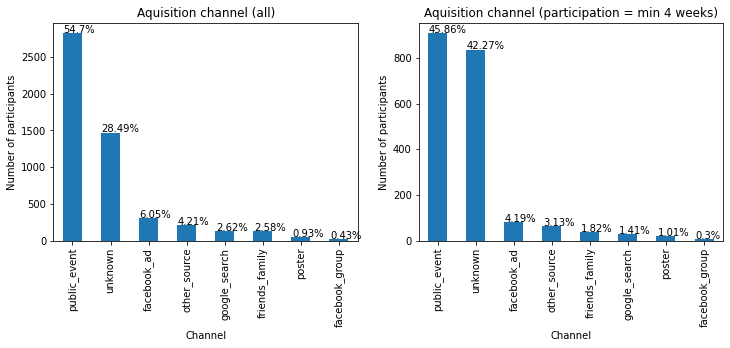

In [20]:
Display.header('Time in the study', 'h1')
Display.header('Acquisition channels', 'h2')

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

df.at[pd.isnull(df['CHANNEL']), 'CHANNEL'] = 'unknown'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

value_counts = df['CHANNEL'].value_counts()
value_counts.plot(kind="bar", title='Aquisition channel (all)', ylabel='Number of participants', xlabel='Channel', ax=ax1)
tag_bars(ax1,  df['CHANNEL'].shape[0])

df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['ENROLED_ON']).dt.days, inplace=True)
df = df[df['TIME_DAYS'] > 4*7]

value_counts = df['CHANNEL'].value_counts()
value_counts.plot(kind="bar", title='Aquisition channel (participation = min 4 weeks)', ylabel='Number of participants', xlabel='Channel', ax=ax2)
tag_bars(ax2,  df['CHANNEL'].shape[0])


Current week: 2021, 41


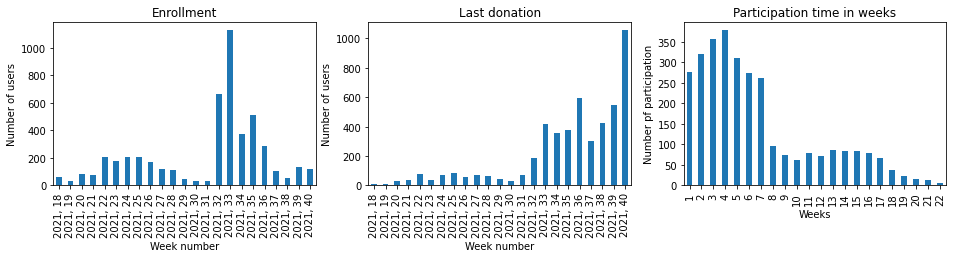

In [13]:
def to_week_number(day):    
    week_now = day.date().isocalendar()[1]
    year_now = day.date().isocalendar()[0]
    return f'{year_now}, {week_now}'

def plot_over_weeks(df, date_column, ax, title, ylabel, xlabel):
    result = df.loc[~pd.isnull(df[date_column])][['ALP_ID', date_column]].copy()
    result['week'] = result[date_column].apply(lambda x: to_week_number(x))
    week_groups = result.groupby(by=['week'])['ALP_ID'].count()
    week_groups.plot(kind='bar',legend=None, title=title, ax=ax, ylabel=ylabel, xlabel=xlabel);
    
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .get()

df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['ENROLED_ON']).dt.days, inplace=True)
df = df[~pd.isnull(df['TIME_DAYS'])]

df['TIME_DAYS'] = df['TIME_DAYS'].astype(int)
df['TIME_WEEKS'] = (df['TIME_DAYS']/7).astype(int)

vc = df['TIME_WEEKS'].value_counts().sort_index()

Display.header('All participants', 'h2')

print(f'Current week: {to_week_number(datetime.now())}')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,3))

plot_over_weeks(df, 'ENROLED_ON', ax1, 'Enrollment', 'Number of users', 'Week number')
plot_over_weeks(df, 'LAST_DONATION', ax2, 'Last donation', 'Number of users', 'Week number')

vc = vc.drop(index=[0])
vc.plot(kind="bar", ax=ax3, title='Participation time in weeks', 
        xlabel='Weeks', ylabel='Number pf participation');

Current week: 2021, 41


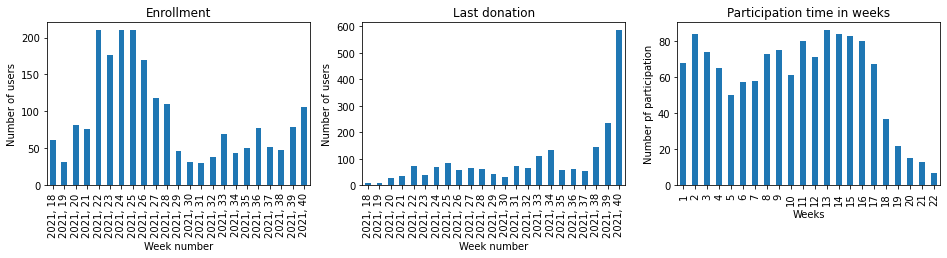

In [108]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

df = df[df['CHANNEL'] != 'public_event']

df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['ENROLED_ON']).dt.days, inplace=True)
df = df[~pd.isnull(df['TIME_DAYS'])]

df['TIME_DAYS'] = df['TIME_DAYS'].astype(int)
df['TIME_WEEKS'] = df.apply(lambda row : group_days_to_weeks(row['TIME_DAYS']), axis = 1)

vc = df['TIME_WEEKS'].value_counts().sort_index()

Display.header('Not including public event', 'h2')
print(f'Current week: {to_week_number(datetime.now())}')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,3))

plot_over_weeks(df, 'ENROLED_ON', ax1, 'Enrollment', 'Number of users', 'Week number')
plot_over_weeks(df, 'LAST_DONATION', ax2, 'Last donation', 'Number of users', 'Week number')

vc = vc.drop(index=[0])
vc.plot(kind="bar", ax=ax3, title='Participation time in weeks', 
        xlabel='Weeks', ylabel='Number pf participation');

Current week: 2021, 41


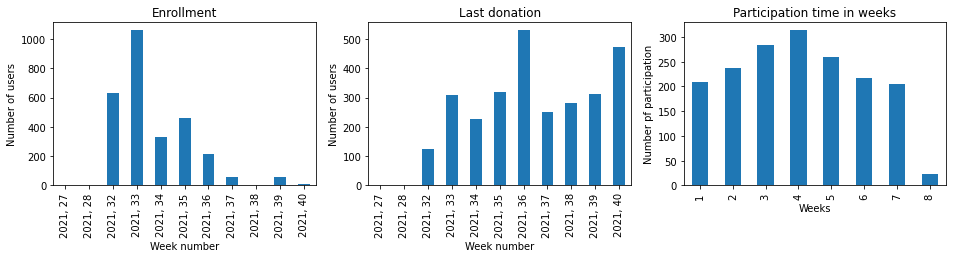

In [109]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

df = df[df['CHANNEL'] == 'public_event']

df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['ENROLED_ON']).dt.days, inplace=True)
df = df[~pd.isnull(df['TIME_DAYS'])]

df['TIME_DAYS'] = df['TIME_DAYS'].astype(int)
df['TIME_WEEKS'] = df.apply(lambda row : group_days_to_weeks(row['TIME_DAYS']), axis = 1)

vc = df['TIME_WEEKS'].value_counts().sort_index()

Display.header('Public event', 'h2')
print(f'Current week: {to_week_number(datetime.now())}')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,3))

plot_over_weeks(df, 'ENROLED_ON', ax1, 'Enrollment', 'Number of users', 'Week number')
plot_over_weeks(df, 'LAST_DONATION', ax2, 'Last donation', 'Number of users', 'Week number')

vc = vc.drop(index=[0])
vc.plot(kind="bar", ax=ax3, title='Participation time in weeks', 
        xlabel='Weeks', ylabel='Number pf participation');

1. enrolled:    Still active
2. suspended:   Left the study but did not revoke consent
3. withdrawn:   Left the study and deleted all data


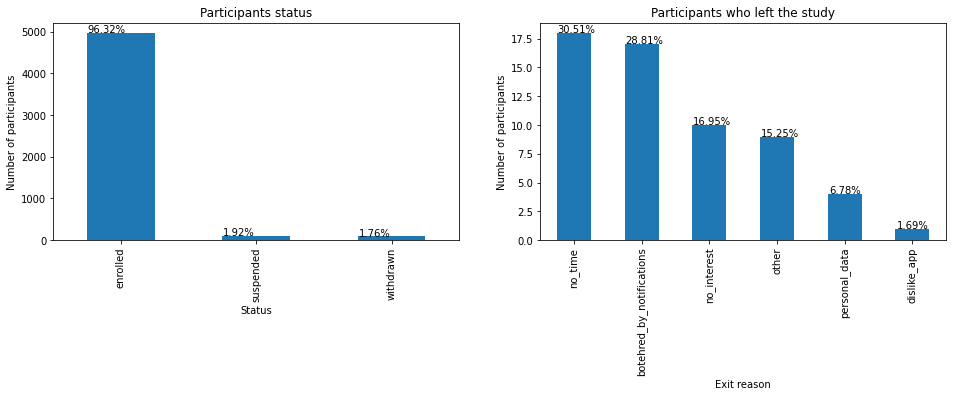

In [156]:
responses_df['QUESTIONNAIRE'].unique()

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_choice('E1_exit_interview','exit_reason', 'EXIT_REASON') \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

df['TIME_IN_STUDY'] = df['LAST_DONATION'] - df['ENROLED_ON']
df = df[~df['EXIT_REASON'].isnull()]

Display.header('Why do participants leave the study?', 'h2')
print(f'{"1. enrolled:":<15} Still active')
print(f'{"2. suspended:":<15} Left the study but did not revoke consent')
print(f'{"3. withdrawn:":<15} Left the study and deleted all data')
# Display.frame(df, 5)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

vc = original_participants_df['STATUS'].value_counts()
vc.plot(kind="bar", title='Participants status', ax=ax1,
        ylabel='Number of participants', xlabel='Status');
tag_bars(ax1, original_participants_df.shape[0])

vc = df['EXIT_REASON'].value_counts()
vc.plot(kind="bar", title='Participants who left the study', ax=ax2,
        ylabel='Number of participants', xlabel='Exit reason');
tag_bars(ax2, df.shape[0])

Number of participants: 2337 (45.3%)


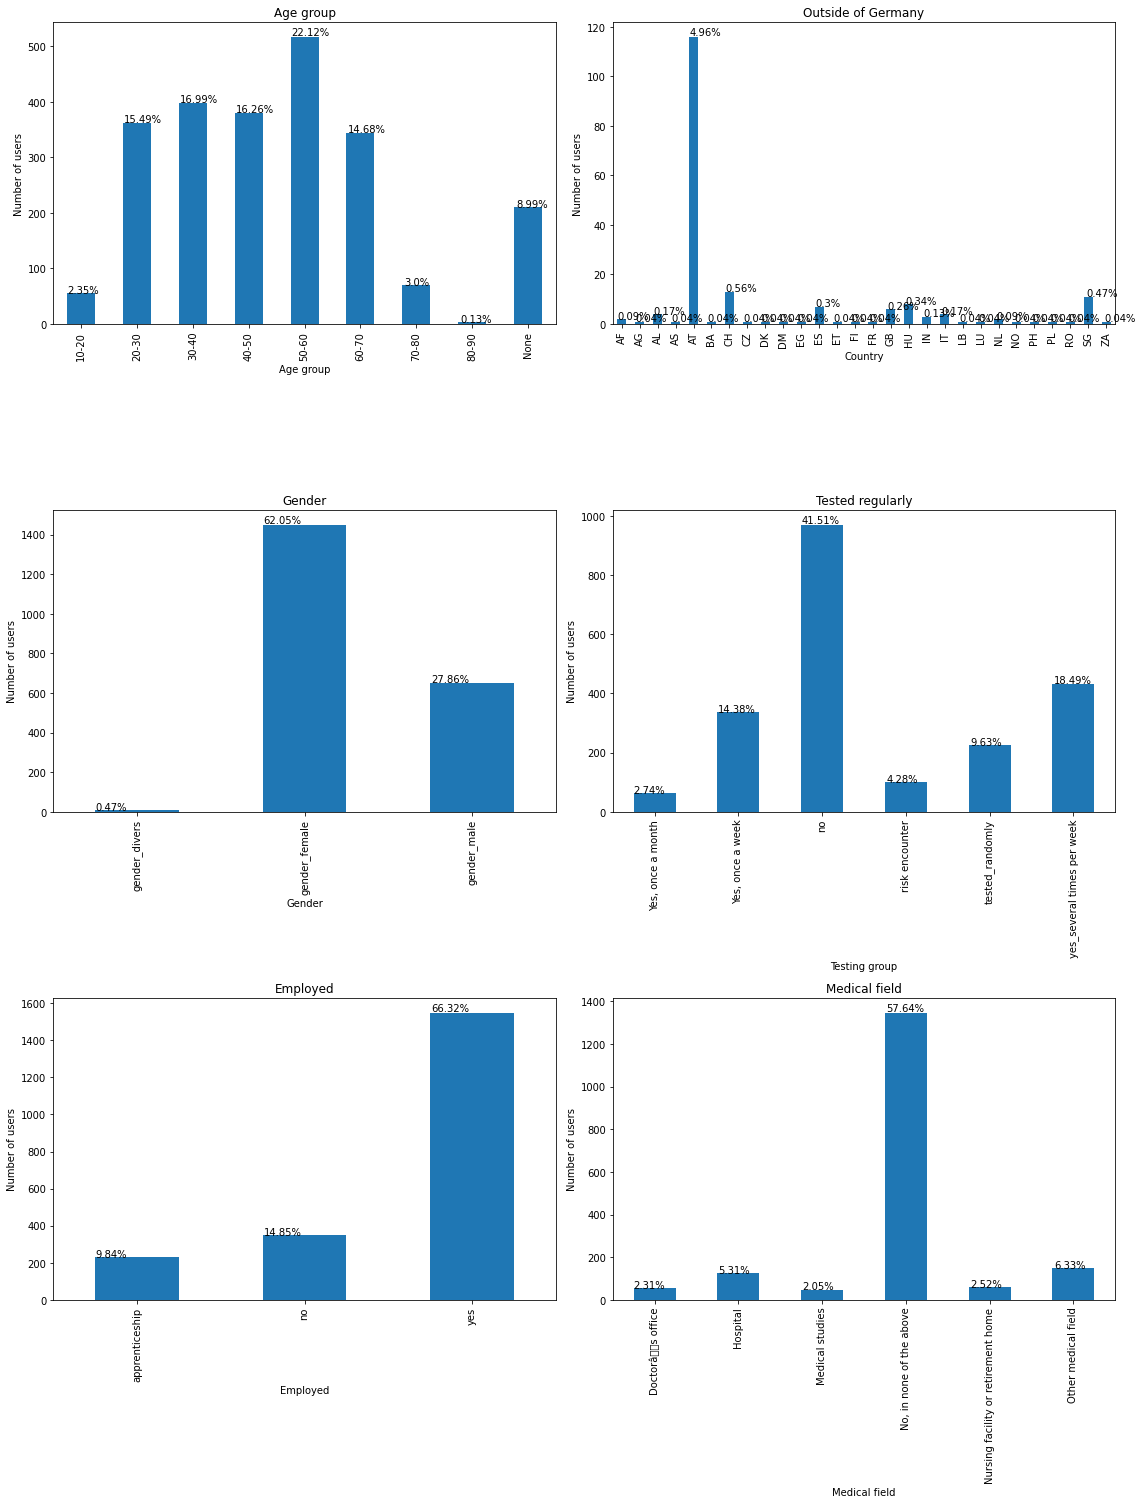

In [8]:
import matplotlib.pyplot as plt
from datetime import date

def get_age_group(year_of_birth):
    if pd.isnull(year_of_birth) | year_of_birth == 0: return 'None'
    year_now = date.today().year
    age = year_now - year_of_birth
    dec_year = 10 * math.floor(age/10)
    return f'{dec_year}-{10+dec_year}'

def bar_distribution(series, ax, title, xlabel, ylabel):
    value_counts = series.value_counts().sort_index()
    value_counts.plot(kind="bar", title=title, ax=ax, ylabel=ylabel, xlabel=xlabel)
    
def draw(result):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,21))
    bar_distribution(result['AGE_GROUP'], ax1, 'Age group', 'Age group', 'Number of users')
    foreign_countries = result[result['COUNTRY'] != 'DE']
    bar_distribution(foreign_countries['COUNTRY'], ax2, 'Outside of Germany', 'Country', 'Number of users')
    bar_distribution(result['GENDER'], ax3, 'Gender', 'Gender', 'Number of users')
    bar_distribution(result['REGULAR_TESTED'], ax4, 'Tested regularly', 'Testing group', 'Number of users')
    bar_distribution(result['EMPLOYED'], ax5, 'Employed', 'Employed', 'Number of users');
    bar_distribution(result['MED_FIELD'], ax6, 'Medical field', 'Medical field', 'Number of users');
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        tag_bars(ax, result.shape[0])
    fig.tight_layout()

def get_demograpgics():
    df = ParticipantsBuilder(study, original_participants_df, responses_df) \
        .add_choice('personal_info','participant_gender', 'GENDER') \
        .add_choice('personal_info','regular_testing', 'REGULAR_TESTED') \
        .add_choice('personal_info','country_of_residence', 'COUNTRY') \
        .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
        .add_choice('personal_info','study_discovery', 'CHANNEL') \
        .add_choice('personal_info','work_medical_field', 'MED_FIELD') \
        .add_choice('personal_info','currently_illnesses', 'ILLNESS') \
        .add_choice('personal_info','do_you_work', 'EMPLOYED') \
        .get()
    df["BIRTH_YEAR"] = df["BIRTH_YEAR"].fillna(0).astype(int)
    df['AGE_GROUP'] = df.apply(lambda row : get_age_group(row['BIRTH_YEAR']), axis = 1)
    return df

Display.header(f'Demographics', 'h1')
Display.header('Participants not including public event', 'h2')

df = get_demograpgics()
count_all = df.shape[0]
df = df[df['CHANNEL'] != 'public_event']
percent = round(100 * df.shape[0] / count_all, 1)
print(f'Number of participants: {df.shape[0]} ({percent}%)')
draw(df)

Number of participants: 2822, (54.7%)


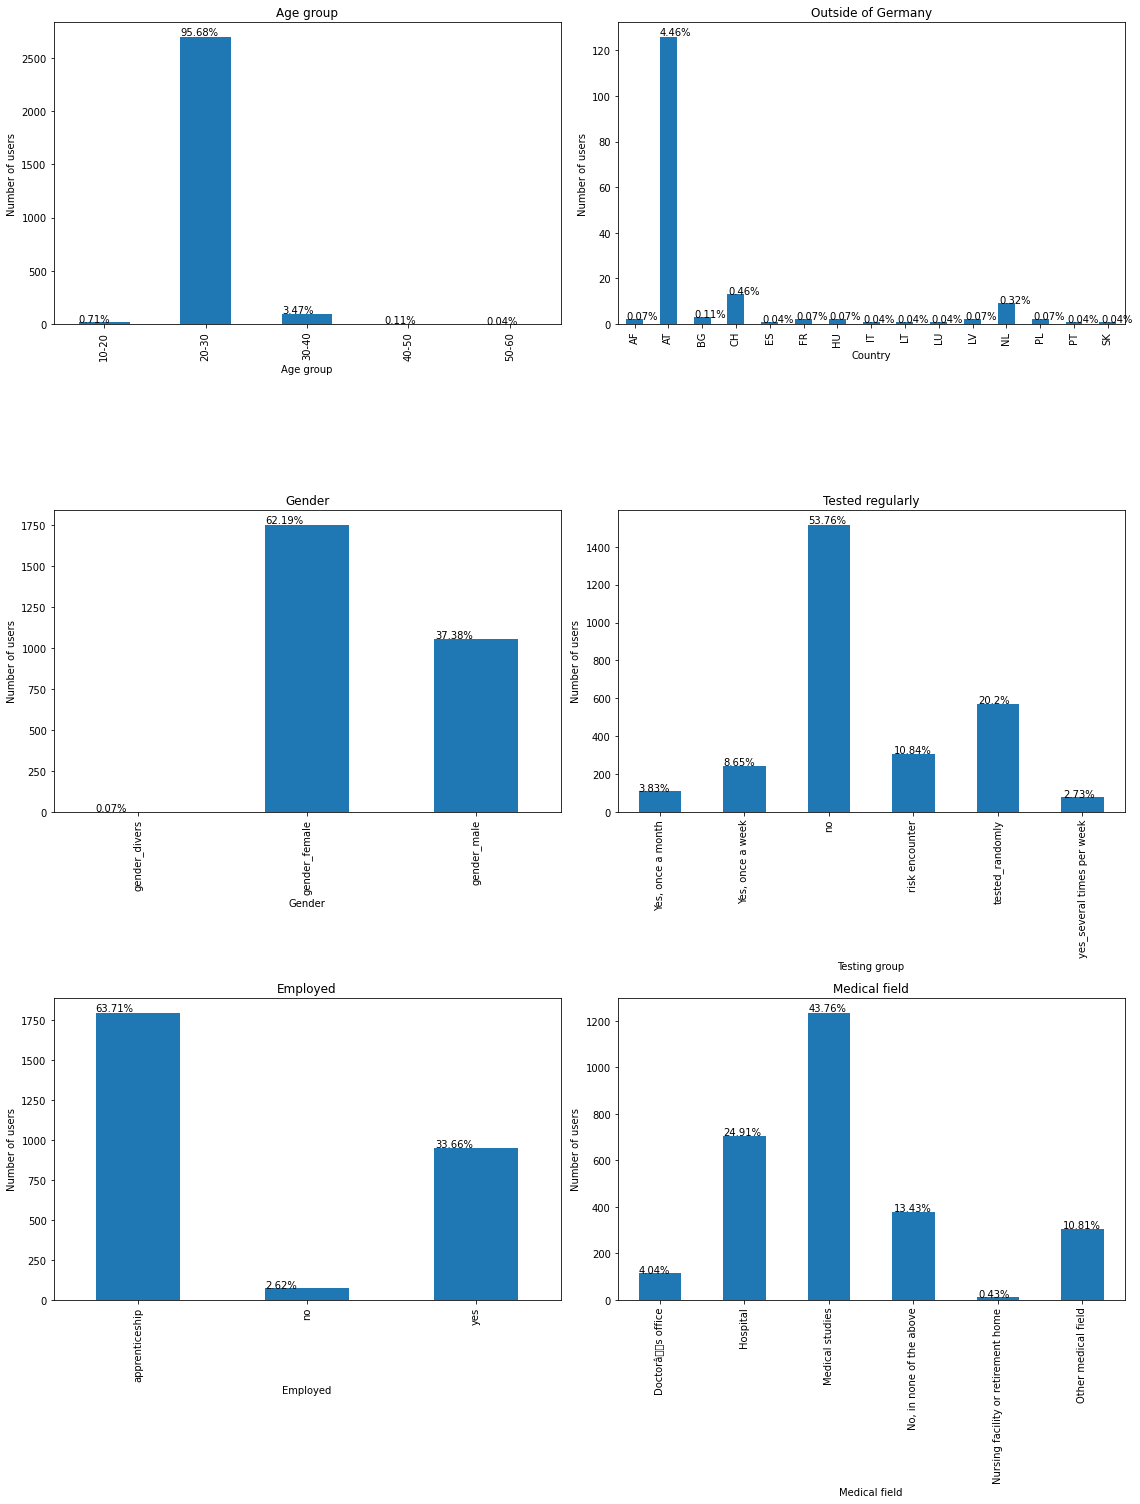

In [9]:
Display.header('Only from public event', 'h2')

df = get_demograpgics()
count_all = df.shape[0]
df = df[df['CHANNEL'] == 'public_event']
percent = round(100 * df.shape[0] / count_all, 1)
print(f'Number of participants: {df.shape[0]}, ({percent}%)')
draw(df)

In [95]:
from datetime import date

from datetime import date, timedelta

class ExposureAnalysis:
    
    @staticmethod
    def get_exposure_dates():
        dates = []
        instance_date = datetime(2021, 4, 7)
        while instance_date.date() < datetime.now().date():
            dates.append(instance_date)
            instance_date = instance_date + timedelta(days=28)
        return dates

    @staticmethod
    def calc_enrollment_group(enrolment_date, exposure_dates):
        for i in range(len(exposure_dates)):
            d = exposure_dates[len(exposure_dates)-i-1]
            if enrolment_date.date() >= d.date():
                return d
            
    @staticmethod
    def exposure_submissions(participants_df, exposure_dates):
        result = participants_df[~participants_df['ENROLED_ON'].isnull()][['ALP_ID', 'ENROLED_ON']].copy()
        result['total'] = 1
        result['ENROLMENT_GROUP'] = result.apply(lambda row : ExposureAnalysis.calc_enrollment_group(
            row['ENROLED_ON'], exposure_dates), axis = 1)
        r = responses_df[responses_df['QUESTIONNAIRE'] == study.questionnaires()['Q3']]
        instance_date = datetime(2021, 4, 7)
        instance_number = 1
        while instance_date.date() < datetime.now().date():
            df = r[(r['AUTHORED'] >= instance_date) & (r['AUTHORED'] < instance_date + timedelta(days=28))].copy()
            column_name = f'Q3:{instance_date.strftime("%d.%m")}'
            df[column_name] = 1
            df = df[['ALP_ID', column_name]].drop_duplicates()
            result = pd.merge(result, df, how='left', on='ALP_ID')
            result[column_name] = result[column_name].fillna(0).astype(int)
            instance_date = instance_date + timedelta(days=28)
            instance_number += 1
        result = result.drop(columns=['ALP_ID', 'ENROLED_ON'])
        result = result.groupby(by=['ENROLMENT_GROUP']).sum()
        return result
    
    @staticmethod
    def show_submissions(df):
        exposure_dates = ExposureAnalysis.get_exposure_dates()[1:]
        exposure_dates.append(exposure_dates[-1] + timedelta(days=28))
        df = ExposureAnalysis.exposure_submissions(df, exposure_dates)
        Display.header(f'Count submissions of every Q3 (exposure questionnaire)', 'h3')
        Display.frame(df,5)

        df2 = df.copy().astype(str)
        for i in range(len(exposure_dates)):
            index = exposure_dates[i].strftime("%Y-%m-%d")
            if index in df.index:
                reference = df.loc[index]['total']
                offset = 1
                column_name = f'Q3:{exposure_dates[i+offset].strftime("%d.%m")}'
                while (column_name in df.columns):
                    df2.loc[index][column_name] = f'{round(100 * (reference - df.loc[index][column_name]) / reference)}%' \
                        if reference > 0 else '0%'
                    reference = df.loc[index][column_name]
                    offset += 1
                    column_name = f'Q3:{exposure_dates[i+offset].strftime("%d.%m")}'      

        df2.replace('0', '-', inplace=True)
        Display.header(f'Loss of participants (in % from previous month)', 'h3')
        print('percentage = (last_month - this_month) / last_month')
        Display.frame(df2,5)

    
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','participant_gender', 'GENDER') \
    .add_choice('personal_info','regular_testing', 'REGULAR_TESTED') \
    .add_choice('personal_info','country_of_residence', 'COUNTRY') \
    .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

Display.header(f'Exposure questionnaire', 'h1')
Display.text('Triggered on Wednesday ever 28 days:')
dates = ExposureAnalysis.get_exposure_dates()
for d in dates:
    print(f'{d.strftime("%d.%m.%Y")}, week: {to_week_number(d)}')
    
Display.header(f'All participants excluding public event', 'h2')
temp = df[df['CHANNEL'] != 'public_event']
ExposureAnalysis.show_submissions(temp)

Display.header(f'Only participants from public event', 'h2')
temp = df[df['CHANNEL'] == 'public_event']
ExposureAnalysis.show_submissions(temp)

07.04.2021, week: 2021, 14
05.05.2021, week: 2021, 18
02.06.2021, week: 2021, 22
30.06.2021, week: 2021, 26
28.07.2021, week: 2021, 30
25.08.2021, week: 2021, 34
22.09.2021, week: 2021, 38


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09
ENROLMENT_GROUP,,,,,,,,
2021-05-05,296,0,0,181,163,138,85,96
2021-06-02,811,0,0,0,535,485,306,281
2021-06-30,404,0,0,0,0,245,157,164
2021-07-28,174,0,0,0,0,0,66,55
2021-08-25,229,0,0,0,0,0,0,80


percentage = (last_month - this_month) / last_month


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09
ENROLMENT_GROUP,,,,,,,,
2021-05-05,296,-,-,39%,10%,15%,38%,-13%
2021-06-02,811,-,-,-,34%,9%,37%,8%
2021-06-30,404,-,-,-,-,39%,36%,-4%
2021-07-28,174,-,-,-,-,-,62%,17%
2021-08-25,229,-,-,-,-,-,-,65%


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09
ENROLMENT_GROUP,,,,,,,,
2021-06-30,2,0,0,0,0,0,0,0
2021-07-28,1775,0,0,0,0,0,1181,593
2021-08-25,977,0,0,0,0,0,0,275
2021-09-22,68,0,0,0,0,0,0,0


percentage = (last_month - this_month) / last_month


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09
ENROLMENT_GROUP,,,,,,,,
2021-06-30,2,-,-,-,-,100%,0%,0%
2021-07-28,1775,-,-,-,-,-,33%,50%
2021-08-25,977,-,-,-,-,-,-,72%
2021-09-22,68,-,-,-,-,-,-,-


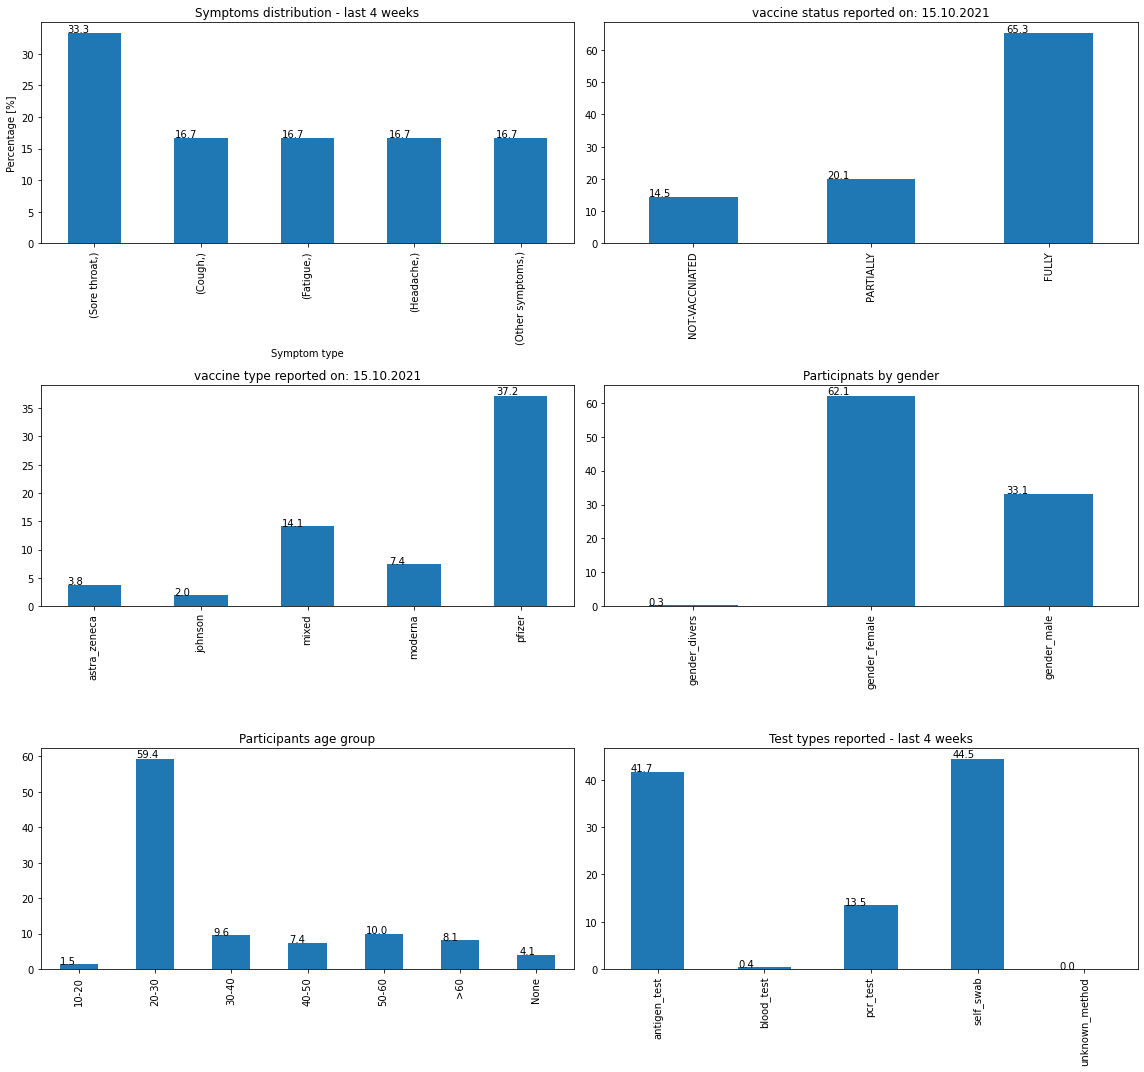

In [158]:
from ecov_utils import Vaccination 
from datetime import datetime

last_donation = responses_df['AUTHORED'].max()
NUM_OF_WEEKS = 4
threshold = last_donation - timedelta(days=7*NUM_OF_WEEKS)

rb = ResponsesBuilder(responses_df)
df = rb.get_choice('SYMPTOMS', 'which_new_symptoms')
df = df[df['AUTHORED'] >= threshold]
vc = round(100 * df[['SYMPTOMS']].value_counts() / df.shape[0], 1)

Display.header('Charts in the study application', 'h1')
Display.text('The charts in this section are available for users in the application')

df = original_participants_df[original_participants_df['STATUS'] != 'withdrawn']
Display.text(f'Participants with valid consent: {df.shape[0]}')
df = original_participants_df[original_participants_df['STATUS'] == 'suspended']
Display.text(f'Participants that left study: {df.shape[0]}')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,15))

vc.plot(kind="bar", ax=ax1, title=f'Symptoms distribution - last {NUM_OF_WEEKS} weeks', 
        xlabel='Symptom type', ylabel='Percentage [%]');

v = Vaccination(original_participants_df, responses_df)

day = datetime.now()
df = v.get_vaccine_status(day)

temp = df[df['status'] != 'UNKNOWN']
value_cnts = round(100 * temp['status'].value_counts()[['NOT-VACCNIATED', 'PARTIALLY', 'FULLY']] / temp.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax2, title=f'vaccine status reported on: {day.strftime("%d.%m.%Y")}')

value_cnts = round(100 * df['type'].value_counts().sort_index() / df.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax3, title=f'vaccine type reported on: {day.strftime("%d.%m.%Y")}')

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','participant_gender', 'GENDER') \
    .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
    .get()

def get_age_group2(year_of_birth):
    if pd.isnull(year_of_birth) | year_of_birth == 0: 
        return 'None'
    year_now = date.today().year
    age = year_now - year_of_birth
    dec_year = 10 * math.floor(age/10)
    if dec_year >= 60:
        return ">60"
    return f'{dec_year}-{10+dec_year}'

df["BIRTH_YEAR"] = df["BIRTH_YEAR"].fillna(0).astype(int)
df['AGE_GROUP'] = df.apply(lambda row : get_age_group2(row['BIRTH_YEAR']), axis = 1)

value_cnts = round(100 * df['GENDER'].value_counts().sort_index() / df.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax4, title='Participnats by gender')

value_cnts = round(100 * df['AGE_GROUP'].value_counts().sort_index() / df.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax5, title='Participants age group');

tests = TestManager(responses_df).get()
tests = tests[tests['AUTHORED'] > threshold]
value_cnts = round(100 * tests['METHOD'].value_counts().sort_index() / tests.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax6, title=f'Test types reported - last {NUM_OF_WEEKS} weeks');

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    tag_bars(ax)
        
fig.tight_layout()